In [1]:
from sklearnex import patch_sklearn, unpatch_sklearn

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [42]:
import sys, sklearn
print(f"python version: {sys.version}")
print(f"scikit-learn version: {sklearn.__version__}")

python version: 3.9.15 (main, Nov 24 2022, 14:31:59) 
[GCC 11.2.0]
scikit-learn version: 1.1.1


In [3]:
X, y = mnist["data"], mnist["target"]
print(type(X), type(y))
print(X.shape, y.shape)

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
(70000, 784) (70000,)


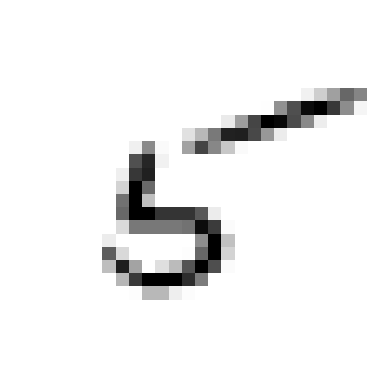

In [4]:
import numpy as np
import matplotlib.pyplot as plt

X = X.to_numpy()
y = y.to_numpy()
# pick random index
random_idx = np.random.randint(X.shape[0])
some_digit = X[random_idx]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [5]:
y = y.astype(np.uint8)

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
# binary classification

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit]) # correct

array([ True])

## 3.3.1 Cross Validation

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_corrects = sum(y_pred == y_test_fold)
    print(n_corrects / len(y_pred))

0.9669
0.91625
0.96785


In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

### 3.3.2 Confusion Matrix

In [12]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [13]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

## 3.3.3 precision and recall

In [14]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


In [15]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

## 3.3.4 precision/recall trade off

In [16]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
print(y_scores > threshold)


[4832.24573075]
[ True]


In [17]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [18]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [19]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [20]:
print(precisions.shape, recalls.shape, thresholds.shape)

(60001,) (60001,) (60000,)


In [21]:
np.linspace(4, 3, 5)

array([4.  , 3.75, 3.5 , 3.25, 3.  ])

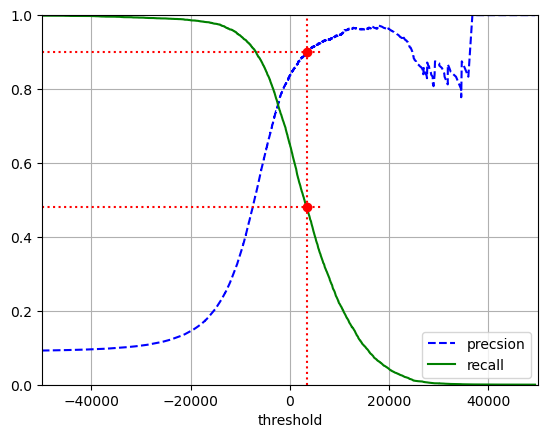

In [40]:
def plot_precision_recall_curve(precisions, recalls, thresholds):
    dot_idx = np.argmax(precisions > 0.9)
    dot_precision = precisions[dot_idx]
    dot_recall = recalls[dot_idx]
    dot_threshold = thresholds[dot_idx]    
    plt.plot(thresholds, precisions[:-1], "b--", label="precsion")
    plt.plot(thresholds, recalls[:-1], "g-", label="recall")
    plt.xlabel("threshold")
    plt.xlim([-50000, 50000])
    plt.ylim([0, 1])
    plt.axvline(x=dot_threshold, color='r', linestyle=':')
    plt.axhline(y=dot_precision, xmin=0, xmax=0.5+dot_threshold/50000, color='r', linestyle=':')
    plt.axhline(y=dot_recall, xmin=0, xmax=0.5+dot_threshold/50000, color='r', linestyle=':')
    plt.plot([dot_threshold, dot_threshold], [dot_precision, dot_recall], 'ro')
    plt.xticks(np.linspace(-40000, 40000, 5))
    plt.grid()
    plt.legend()
    plt.show()

plot_precision_recall_curve(precisions, recalls, thresholds)

## 3.3.5 ROC 곡선

In [41]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

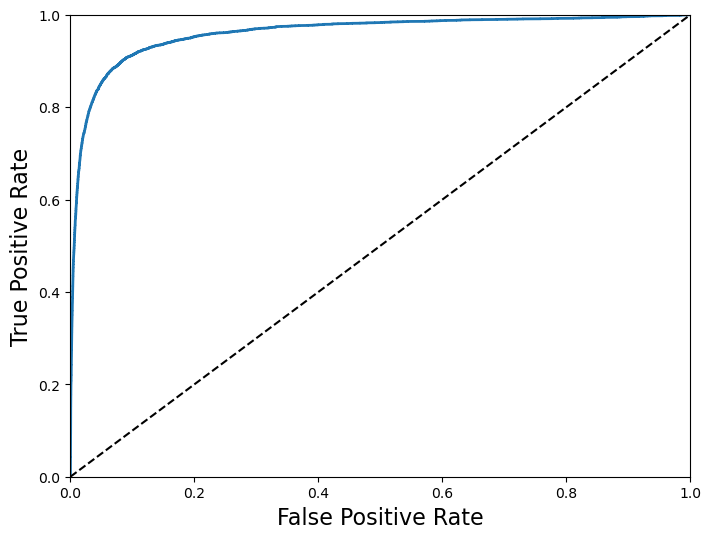

In [43]:
def plot_roc_curve_func(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve_func(fpr, tpr)
plt.show()

/opt/conda/envs/intelex/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


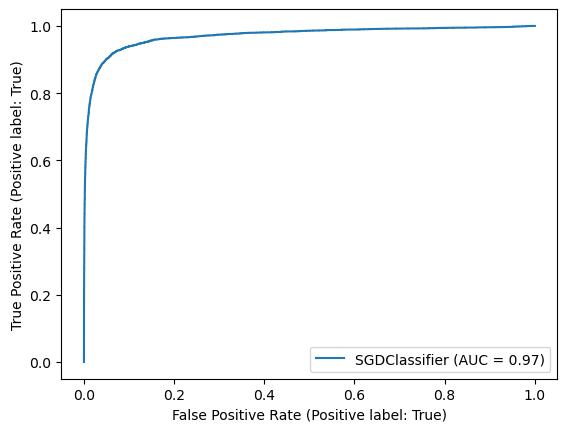

In [44]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(sgd_clf, X_train, y_train_5)
plt.show()

In [45]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

> 랜덤 분류기는 왜 AUC 면적이 0.5 될 것이라고 하는가?

+ AUROC의 x축은 $FPR = \frac{FP}{TN+FP}$,  y축은 $TPR = \frac{TP}{TP+FN}$
+ 랜덤 분류기라면 positive를 맞출 확률, negative를 맞출 확률 모두 0.5가 될 것
+ 즉, $TP = FP$, $TN = FN$ 이 될 것으로 예상할 수 있다.
+ 위의 조건을 $FPR$ 에 대입해 보면 $FPR = \frac{FP}{TN+FP} = \frac{TP}{FN+TP} = TPR$ 
+ $TPR=FPR$ 의 조건을 만족하는 $y=x$의 대각선을 그릴 것으로 예상할 수 있으며 $AUC=0.5$ 로 예상할 수 있다.


In [46]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [47]:
print(type(y_probas_forest))

<class 'numpy.ndarray'>


In [48]:
print(y_probas_forest.shape)

(60000, 2)


In [49]:
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용합니다.
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

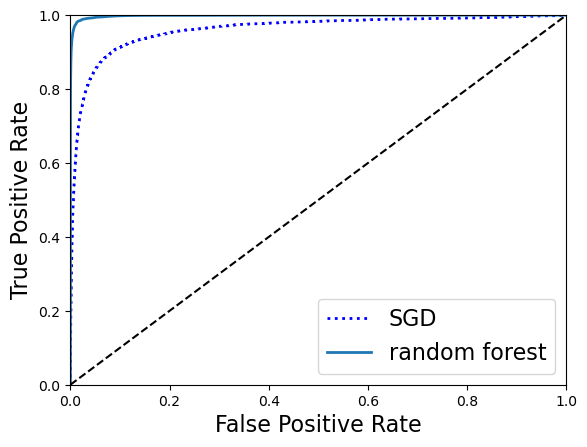

In [51]:
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve_func(fpr_forest, tpr_forest, "random forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [52]:
roc_auc_score(y_train_5, y_scores_forest)

0.9985197691011494

## 3.4 다중분류

+ One-versus-the-Rest / One-versus-All (OvR, OvA): 클래스 별 이진 분류기(각 클래스에 해당하는 데이터와 나머지 클래스에 해당하는 데이터)
  + 각 클래스 수와 동일한 개수의 모델이 필요함
+ One-versus-One (OvO): 두 클래스 조합 별 이진 분류기(두 클래스에 속하는 데이터만)
  + $N \times (N-1) / 2$ 개의 모델이 필요함
+ SVM과 같이 훈련 데이터 크기에 민감한 알고리즘은 많은 수의 모델을 작은 데이터크기로 학습시키는 것이 유리함
+ 대부분의 이진분류는 OvR이 유리함

In [53]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [55]:
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)
print(np.argmax(some_digit_scores))
print(svm_clf.classes_)
print(svm_clf.classes_[np.argmax(some_digit_scores)])

[[ 1.78793277  2.78215068  6.16990669 -0.29481243  8.26692316  9.30708003
   6.08886304  3.81323298  5.91315064  0.73071819]]
5
[0 1 2 3 4 5 6 7 8 9]
5


+ sklearn에서 OvO, OvR을 사용하도록 강제하려면
  + OneVsOneClassifier <- OvO
  + OneVsRestClassifier <-OvR 

In [56]:
# SVC OvR 전략 사용
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
print(ovr_clf.predict([some_digit]))
print(len(ovr_clf.estimators_))


[5]
10
